In [1]:
!ls 

Fairness_on_Regression_Tasks.ipynb data_exploration.ipynb
README.md                          dataset-cleaning.ipynb
data                               ml_curated_data


In [2]:
!ls data/*

data/communities.data
data/communities.names
data/communities_and_crime.csv
data/communities_and_crime_clean.csv
data/communities_and_crime_cleaner_no_unknowns.csv


In [3]:
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
import pandas as pd
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.5f}'.format

from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import tensorflow.keras as keras

from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from numpy.polynomial.polynomial import polyfit
import numpy as np

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tensorflow.python.data import Dataset
from sklearn import metrics
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version:  2.0.0


In [4]:
SEED = 1
from numpy.random import seed
seed(SEED)
try:
    tf.random.set_seed(SEED)
except:
    print(" Could not set tensorflow seed. Need tensorflow core version 2")

# Enable eager execution

In [5]:
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()
assert not tf.executing_eagerly()

In [6]:
data = pd.read_csv("data/communities_and_crime_clean.csv")

In [7]:
data.head()

,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,1,0.19000,0.33000,0.02000,0.90000,0.12000,0.17000,0.34000,0.47000,0.29000,...,0.12000,0.42000,0.50000,0.51000,0.64000,0.12000,0.26000,0.20000,0.32000,0.20000
1,1,0.00000,0.16000,0.12000,0.74000,0.45000,0.07000,0.26000,0.59000,0.35000,...,0.21000,0.50000,0.34000,0.60000,0.52000,0.02000,0.12000,0.45000,0.00000,0.67000
2,1,0.00000,0.42000,0.49000,0.56000,0.17000,0.04000,0.39000,0.47000,0.28000,...,0.14000,0.49000,0.54000,0.67000,0.56000,0.01000,0.21000,0.02000,0.00000,0.43000
3,1,0.04000,0.77000,1.00000,0.08000,0.12000,0.10000,0.51000,0.50000,0.34000,...,0.19000,0.30000,0.73000,0.64000,0.65000,0.02000,0.39000,0.28000,0.00000,0.12000
4,1,0.01000,0.55000,0.02000,0.95000,0.09000,0.05000,0.38000,0.38000,0.23000,...,0.11000,0.72000,0.64000,0.61000,0.53000,0.04000,0.09000,0.02000,0.00000,0.03000


In [8]:
data.shape

(1994, 101)

In [9]:
data.to_csv("data/communities_and_crime_cleaner_no_unknowns.csv")

In [10]:
def train_test_split(data, folds=[10]):
    folds = set(folds)
    training_data = data.copy()
    test_data = None
    for fold_number in folds:
        training_data = training_data[training_data.fold != fold_number]
        new_test_data = data[data.fold == fold_number]
        if test_data is None:
            test_data = new_test_data
        else:
            test_data = pd.concat([test_data, new_test_data])
    return training_data, test_data

In [11]:
training_data, test_data = train_test_split(data, folds=[10])

In [12]:
training_data.shape,test_data.shape

((1795, 101), (199, 101))

In [13]:
training_data.drop(['fold'], axis=1).describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
count,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,...,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000
mean,0.05714,0.46432,0.17949,0.75329,0.15374,0.14490,0.42489,0.49388,0.33678,0.42389,...,0.21590,0.60812,0.53499,0.62622,0.65119,0.06529,0.23136,0.16296,0.09469,0.23915
std,0.12531,0.16463,0.25386,0.24489,0.20809,0.23371,0.15645,0.14433,0.16816,0.17921,...,0.23148,0.20476,0.18160,0.20125,0.19869,0.10789,0.20144,0.22988,0.24097,0.23554
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.01000,0.35000,0.02000,0.63000,0.04000,0.01000,0.33000,0.41000,0.25000,0.30000,...,0.06000,0.47000,0.42000,0.53000,0.56000,0.02000,0.10000,0.02000,0.00000,0.07000
50%,0.02000,0.44000,0.06000,0.85000,0.08000,0.04000,0.40000,0.47000,0.29000,0.42000,...,0.13000,0.63000,0.55000,0.67000,0.70000,0.04000,0.17000,0.07000,0.00000,0.15000
75%,0.05000,0.54000,0.23000,0.94000,0.17000,0.16000,0.47000,0.54000,0.36000,0.53000,...,0.28000,0.77500,0.66000,0.77000,0.79000,0.07000,0.28000,0.19000,0.00000,0.33000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,0.99000,0.99000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [14]:
test_data.describe()

,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
count,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,...,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000
mean,10.00000,0.06166,0.45503,0.18090,0.75754,0.15317,0.13613,0.41819,0.49372,0.33161,...,0.21241,0.61583,0.53563,0.62824,0.65462,0.06472,0.24633,0.15015,0.08829,0.22739
std,0.00000,0.14077,0.15538,0.25030,0.23681,0.21638,0.22156,0.14361,0.13681,0.15111,...,0.22850,0.20077,0.17953,0.19428,0.19442,0.12300,0.21753,0.22168,0.23498,0.20881
min,10.00000,0.00000,0.08000,0.00000,0.00000,0.01000,0.00000,0.03000,0.05000,0.03000,...,0.00000,0.00000,0.06000,0.00000,0.00000,0.00000,0.02000,0.00000,0.00000,0.01000
25%,10.00000,0.01000,0.35000,0.02000,0.64000,0.03000,0.01000,0.35000,0.42000,0.26000,...,0.05000,0.47000,0.41500,0.50500,0.53500,0.02000,0.10000,0.02000,0.00000,0.08000
50%,10.00000,0.02000,0.43000,0.07000,0.85000,0.06000,0.04000,0.40000,0.48000,0.30000,...,0.12000,0.66000,0.54000,0.66000,0.71000,0.04000,0.17000,0.06000,0.00000,0.16000
75%,10.00000,0.06000,0.53500,0.22000,0.94000,0.16000,0.15000,0.47000,0.54000,0.35500,...,0.31000,0.77500,0.65000,0.77000,0.78500,0.07000,0.31500,0.18000,0.00000,0.29000
max,10.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,0.94000,1.00000,1.00000,1.00000,1.00000,1.00000


### Violent crimes per population 

Text(0, 0.5, 'racePctWhite')

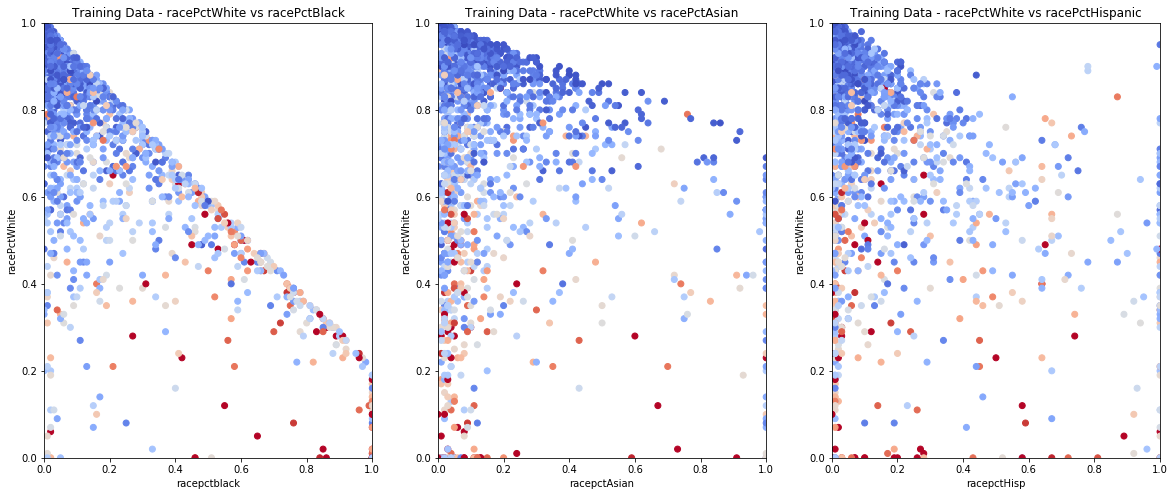

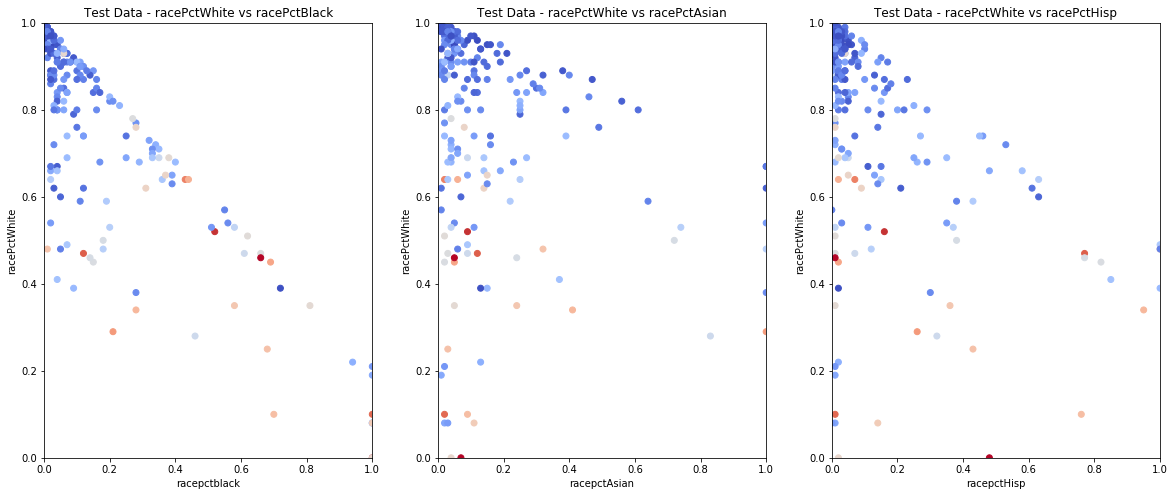

In [15]:

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(131)
ax.set_title("Training Data - racePctWhite vs racePctBlack")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

ax.set_xlabel("racepctblack")
ax.set_ylabel("racePctWhite")

plt.scatter(training_data['racepctblack'],training_data['racePctWhite'], cmap='coolwarm', c=training_data['ViolentCrimesPerPop'])

ax = plt.subplot(1, 3, 2)
ax.set_title("Training Data - racePctWhite vs racePctAsian")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

ax.set_xlabel("racepctAsian")
ax.set_ylabel("racePctWhite")

plt.scatter(training_data['racePctAsian'], training_data['racePctWhite'], cmap='coolwarm', c=training_data['ViolentCrimesPerPop'])

ax = plt.subplot(1, 3, 3)
ax.set_title("Training Data - racePctWhite vs racePctHispanic")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

plt.scatter(training_data['racePctHisp'], training_data['racePctWhite'], cmap='coolwarm', c=training_data['ViolentCrimesPerPop'])
ax.set_xlabel("racepctHisp")
ax.set_ylabel("racePctWhite")


## For validation data


fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(131)
ax.set_title("Test Data - racePctWhite vs racePctBlack")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

ax.set_xlabel("racepctblack")
ax.set_ylabel("racePctWhite")

plt.scatter(test_data['racepctblack'],test_data['racePctWhite'], cmap='coolwarm', c=test_data['ViolentCrimesPerPop'])

ax = plt.subplot(1, 3, 2)
ax.set_title("Test Data - racePctWhite vs racePctAsian")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

ax.set_xlabel("racepctAsian")
ax.set_ylabel("racePctWhite")

plt.scatter(test_data['racePctAsian'], test_data['racePctWhite'], cmap='coolwarm', c=test_data['ViolentCrimesPerPop'])

ax = plt.subplot(1, 3, 3)
ax.set_title("Test Data - racePctWhite vs racePctHisp")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

plt.scatter(test_data['racePctHisp'], test_data['racePctWhite'], cmap='coolwarm', c=test_data['ViolentCrimesPerPop'])
ax.set_xlabel("racepctHisp")
ax.set_ylabel("racePctWhite")

### Train model on the data

In [16]:
VIOLENT_CRIMES_PER_POP = "ViolentCrimesPerPop"
FOLD = "fold"

In [17]:
test_targets =pd.DataFrame()
training_input, training_targets = training_data.drop([FOLD, VIOLENT_CRIMES_PER_POP], axis=1), training_data[VIOLENT_CRIMES_PER_POP]
test_input, test_targets[VIOLENT_CRIMES_PER_POP] = test_data.drop([FOLD, VIOLENT_CRIMES_PER_POP], axis=1), test_data[VIOLENT_CRIMES_PER_POP]

In [18]:
training_input.keys()

Index(['population', 'householdsize', 'racepctblack', 'racePctWhite',
       'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
       'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome',
       'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst',
       'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap',
       'indianPerCap', 'AsianPerCap', 'HispPerCap', 'NumUnderPov',
       'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore',
       'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ',
       'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr',
       'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par',
       'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids',
       'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent',
       'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig',
       'PctRecImmig5', 'PctRecImmig8', 'PctRec

In [19]:
test_input.shape, test_targets.shape

((199, 99), (199, 1))

### Attempt 1: Keras model

In [20]:
INPUT_SIZE = len(training_input.keys())

In [21]:

def build_model():
    model = keras.Sequential([
        Dense(64, activation='relu', input_shape=[INPUT_SIZE]),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    rmsprop = keras.optimizers.RMSprop(0.001)
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mse', optimizer = sgd,  metrics=['mae', 'mse'])
    return model
    

In [22]:
    
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                6400      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 8,513
Trainable params: 8,513
Non-trainable params: 0
_________________________________________________________________


In [23]:
def plot_predicted_vs_true_value(true_values, predicted_values, title="Predicted values vs True value"):
    fig = plt.figure(figsize=(10, 10))
    plt.title("True value vs untrained output")
    plt.scatter(true_values, predicted_values)
    plt.xlabel("True Value")
    plt.ylabel("Predicted value")
    plt.title(title)
    plt.show()

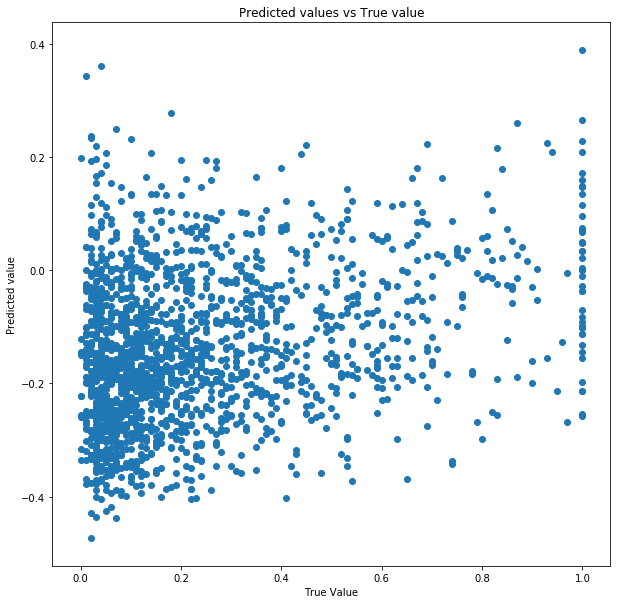

In [24]:
plot_predicted_vs_true_value(training_targets, model.predict(training_input))

In [25]:
class PrintProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')
            
EPOCHS = 100

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    training_input, training_targets, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintProgress()])


.........................................

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
36,0.01522,0.08540,0.01522,0.01691,0.09283,0.01691,36
37,0.01513,0.08390,0.01513,0.01856,0.10212,0.01856,37
38,0.01525,0.08475,0.01525,0.01719,0.09072,0.01719,38
39,0.01512,0.08423,0.01512,0.01760,0.09713,0.01760,39
40,0.01496,0.08357,0.01496,0.01730,0.09654,0.01730,40


Text(0, 0.5, 'Prediction')

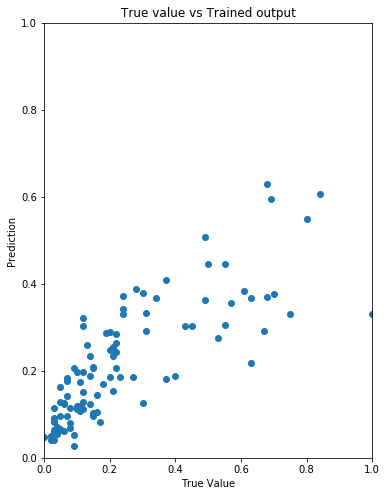

In [27]:
example_batch = training_input[:100]
example_output = model.predict(example_batch)
example_true_output = training_targets[:10]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(131)
ax.set_title("True value vs Trained output")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.scatter(training_targets[:100], example_output[:100])
plt.xlabel("True Value")
plt.ylabel("Prediction")

KeyError: 'mean_absolute_error'

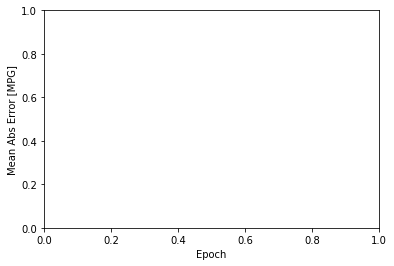

In [28]:
def plot_history(history):
    MAE = 'mean_absolute_error'
    VAL_MAE='val_mean_absolute_error'
    MSE="mean_squared_error"
    VAL_MSE = "val_mean_squared_error"
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist[MAE],
             label='Train Error')
    plt.plot(hist['epoch'], hist[VAL_MAE],
           label = 'Val Error')
    
    plt.ylim([0,0.3])
    plt.legend()
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist[MSE],
           label='Train Error')
    plt.plot(hist['epoch'], hist[VAL_MSE],
           label = 'Val Error')
    plt.ylim([0,0.3])
    plt.legend()
    plt.show()

plot_history(history)

In [29]:
loss, mae, mse = model.evaluate(test_input, test_targets, verbose=2)

199/199 - 0s - loss: 0.0179 - mae: 0.0920 - mse: 0.0179


In [30]:
print("Testing set Mean Abs Error: {:5.2f} ".format(mae))

Testing set Mean Abs Error:  0.09 


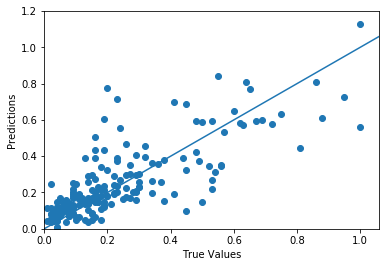

In [31]:
test_predictions = model.predict(test_input)
plt.scatter(test_targets, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-2, 2], [-2, 2])

In [32]:
def plot_crime_error_histogram(predictions, targets, bins=25):
    error = predictions - targets
    plt.hist(error[VIOLENT_CRIMES_PER_POP], bins = 25)
    plt.xlabel("Prediction Error ( ViolentCrimes Per Pop)")
    _ = plt.ylabel("Count")
    plt.show()


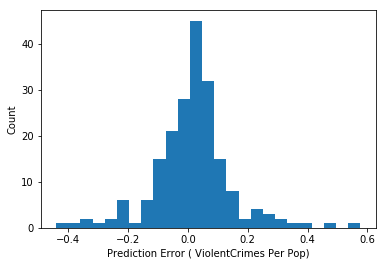

In [33]:
plot_crime_error_histogram(test_predictions, test_targets)

##### Error follows gaussian distribution

### Bias analysis on test data


In [34]:
test_input.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
count,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,...,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000
mean,0.06166,0.45503,0.18090,0.75754,0.15317,0.13613,0.41819,0.49372,0.33161,0.41658,...,0.03246,0.21241,0.61583,0.53563,0.62824,0.65462,0.06472,0.24633,0.15015,0.08829
std,0.14077,0.15538,0.25030,0.23681,0.21638,0.22156,0.14361,0.13681,0.15111,0.17924,...,0.13820,0.22850,0.20077,0.17953,0.19428,0.19442,0.12300,0.21753,0.22168,0.23498
min,0.00000,0.08000,0.00000,0.00000,0.01000,0.00000,0.03000,0.05000,0.03000,0.01000,...,0.00000,0.00000,0.00000,0.06000,0.00000,0.00000,0.00000,0.02000,0.00000,0.00000
25%,0.01000,0.35000,0.02000,0.64000,0.03000,0.01000,0.35000,0.42000,0.26000,0.29000,...,0.00000,0.05000,0.47000,0.41500,0.50500,0.53500,0.02000,0.10000,0.02000,0.00000
50%,0.02000,0.43000,0.07000,0.85000,0.06000,0.04000,0.40000,0.48000,0.30000,0.41000,...,0.00000,0.12000,0.66000,0.54000,0.66000,0.71000,0.04000,0.17000,0.06000,0.00000
75%,0.06000,0.53500,0.22000,0.94000,0.16000,0.15000,0.47000,0.54000,0.35500,0.52000,...,0.00000,0.31000,0.77500,0.65000,0.77000,0.78500,0.07000,0.31500,0.18000,0.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,0.94000,1.00000,1.00000,1.00000,1.00000


# Evaluate Estimation Error coefficient ( Group Fairness) 

In [35]:
def plot_crime_estimation_error_coeffs(input_examples, crime_predictions, crime_targets, abs_value=False):
    
    crime_error = (crime_predictions - crime_targets)[VIOLENT_CRIMES_PER_POP]
    crime_error = crime_error.abs() if abs_value else crime_error
    
    ERROR_LABEL = 'MSE'
    
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(141)
    ax.set_title("White ratio vs MSE")

    ax.set_xlabel("racePctWhite")
    ax.set_ylabel(ERROR_LABEL)
    plt.scatter(input_examples.racePctWhite,crime_error)
    b, m = polyfit(input_examples.racePctWhite, crime_error, 1)
    plt.plot(input_examples.racePctWhite,  b + m *input_examples.racePctWhite, '-')

    ax = plt.subplot(142)
    ax.set_title("Black ratio vs MSE")

    ax.set_xlabel("racePctBlack")
    ax.set_ylabel(ERROR_LABEL)
    plt.scatter(input_examples.racepctblack, crime_error)
    b, m = polyfit(input_examples.racepctblack, crime_error, 1)
    plt.plot(input_examples.racepctblack,  b + m *input_examples.racepctblack, '-')

    ax = plt.subplot(143)
    ax.set_title("Test Data - Error vs racePctAsian")
    plt.scatter(input_examples.racePctAsian, crime_error)
    ax.set_xlabel("racepctAsian")
    ax.set_ylabel(ERROR_LABEL)
    b, m = polyfit(input_examples.racePctAsian, crime_error, 1)
    plt.plot(input_examples.racePctAsian,  b + m *input_examples.racePctAsian, '-')

    ax = plt.subplot(144)
    ax.set_title("Test Data - Error vs racepctHisp")
    plt.scatter(input_examples.racePctHisp, crime_error)
    ax.set_xlabel("racepctHisp")
    ax.set_ylabel(ERROR_LABEL)
    b, m = polyfit(input_examples.racePctHisp, crime_error, 1)
    plt.plot(input_examples.racePctHisp,  b + m *input_examples.racePctHisp, '-')
    plt.subplots_adjust(wspace=0.3)
    plt.show()

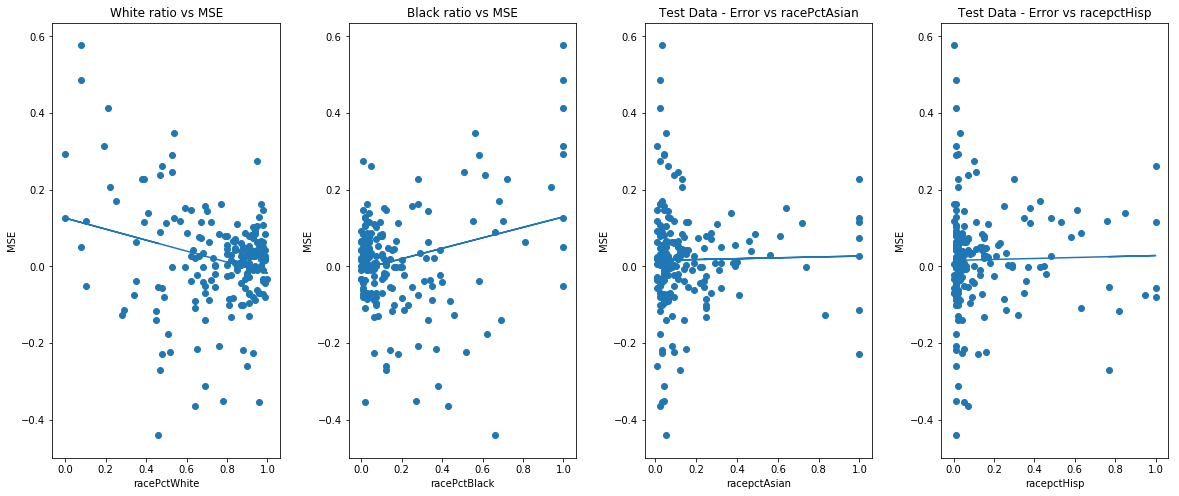

In [36]:
plot_crime_estimation_error_coeffs(test_input, test_predictions, test_targets)

##### Results: We see negative coefficients for racePctWhite, racePctAsian and racePctHispanic, while we see positive coefficient for racePctBlack.

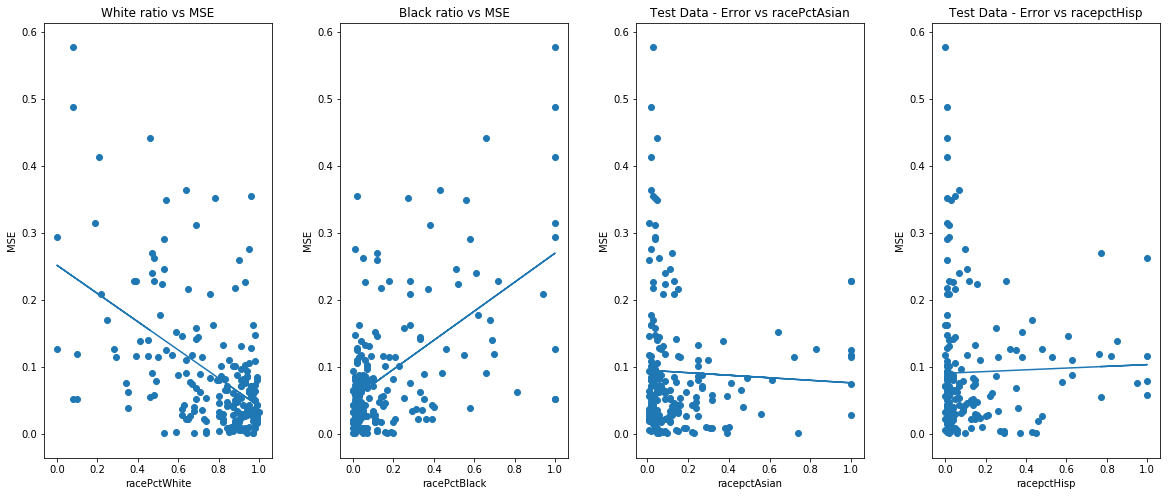

In [37]:
plot_crime_estimation_error_coeffs(test_input, test_predictions, test_targets, abs_value=True)

## Evaluate consistency ( Individual Fairness)

In [38]:
# Compute pairwise euclidean distances in input

def compute_pairwise_euclidean_distances(vec):
    """
    Compute pairwise distances
    Source: https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    """
    A = tf.convert_to_tensor(vec, dtype=tf.float32)
    r = K.sum(A*A, axis=1)
    # turn r into column vector ( -1 is inferred to be n)
    r = K.reshape(r, [-1, 1])
    D = r - 2*K.dot(A, K.transpose(A)) + K.transpose(r)
    return D

def test_compute_pairwise_euclidean_distances():
    distances = compute_pairwise_euclidean_distances(np.array([[1], [2], [3]]))
    sess = tf.compat.v1.Session()
    output_distances = sess.run(distances)

    expected_distances = tf.constant([[0., 1., 4.],
       [1., 0., 1.],
       [4., 1., 0.]], dtype=tf.float32)
    expected_distances_val = sess.run(expected_distances)
    assert np.sum(np.abs(expected_distances_val - output_distances)) == 0, "Euclidean distances do not match"
    
test_compute_pairwise_euclidean_distances()

### Evaluate consistency of prediction

In [39]:
def plot_consistency(X_examples, Y_examples, ax=None, x_label='Input Distance', y_label='Prediction Distance', title= None):
    if title is None:
        title = x_label + " vs " + y_label
        
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.subplot(111)
    session = tf.compat.v1.Session()
    X_pairwise_distances = session.run(compute_pairwise_euclidean_distances(np.array(X_examples)))
    Y_pairwise_distances = session.run(compute_pairwise_euclidean_distances(np.array(Y_examples)))
    # TODO(audace): normalize 
    plt.scatter(X_pairwise_distances,Y_pairwise_distances)
    ax.set_xlabel("Input distance")
    ax.set_ylabel(y_label)
    ax.set_title(title)

plot_consistency(test_input, model.predict(test_input), x_label="Input Dinstace", y_label="Prediction Dinstace", title="Prediction Consistency")

In [40]:
def plot_consistencies(input_examples, target_examples, model, add_overlay=True):
    n_plots = 4 if add_overlay else 3
    fig = plt.figure(figsize=(20, 10))
    ax1 = plt.subplot(1, n_plots, 1)
    predictions = model.predict(input_examples)
    plot_consistency(input_examples, target_examples, ax=ax1, x_label="Input Distances", y_label="True value distances", title="Consistency of true value")
    ax2 = plt.subplot(1, n_plots, 2)
    plot_consistency(input_examples, predictions, ax=ax2, x_label="Input Distances", y_label="Predicted value distances", title="Consistency of Predictions")
    ax3 = plt.subplot(1, n_plots, 3)
    errors = target_examples - predictions
    plot_consistency(input_examples, errors, ax=ax3, x_label="Input distances", y_label="Error distances")
    
    # Plot overlay
    if add_overlay:
        ax = plt.subplot(1, n_plots, 4)
        plot_consistency(input_examples, target_examples, ax=ax, x_label="Input Distances", y_label="True value distances", title="Consistency of true value")
        plot_consistency(input_examples, predictions, ax=ax, x_label="Input Distances", y_label="Predicted value distances", title="Consistency of Predictions")
        plot_consistency(input_examples, errors, ax=ax, x_label="Input distances", y_label="Error distances")
        ax.set_title("Overlay")
        ax.set_xlabel("Input Distance")
        ax.set_ylabel("Metric")


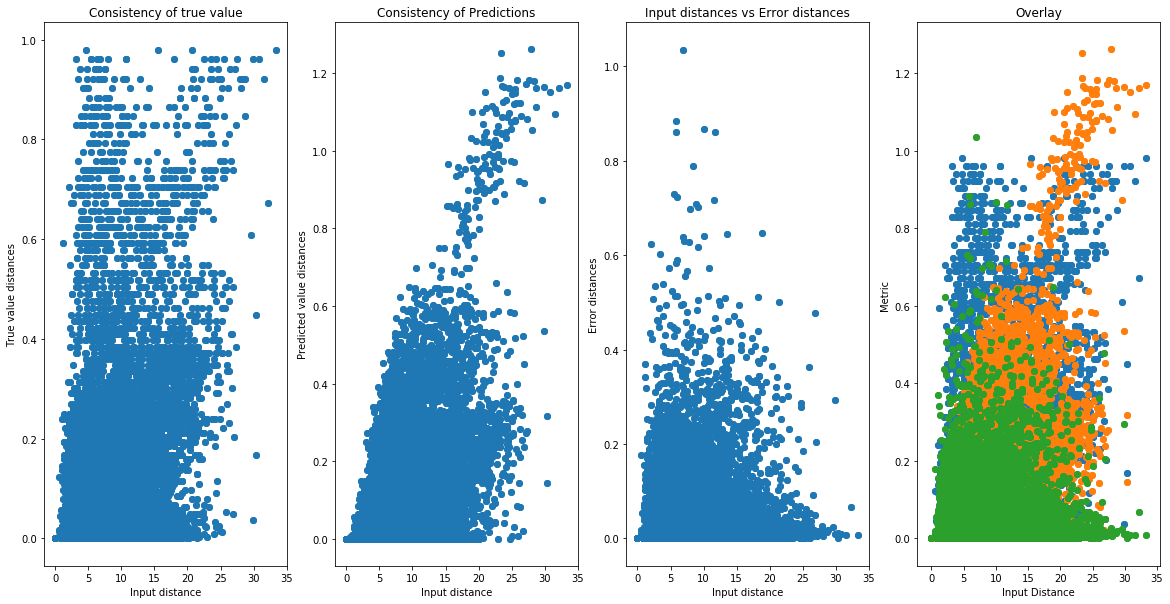

In [41]:
plot_consistencies(test_input, test_targets, model)

### Architecture 2: Linear regressor with tensorflow.estimator.LinearRegressor

In [42]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    ## Convert data into a dict of np array
    features = {key: np.array(value) for key, value in dict(features).items()}
    
    ## Construct dataset, and consider batching and repeating
    ds = Dataset.from_tensor_slices((features, targets)) # 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(100)
        
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

def construct_feature_columns(input_features):
    """
    features: the names of numerical features to use
    Returns a set of feature column
    """
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

def train_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):
    
    """Trains a linear regression model of multiple features.
    
    In addition to training, this function also prints training progress information, as well as a plot of the training and validation loss over time.
    
    Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
    Returns:
    A `LinearRegressor` object trained on the training data.
    """
    periods = 15
    print("Periods: ", periods)
    steps_per_period = steps/periods
    
    
    # Create a linear regression object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_columns(training_examples), optimizer=my_optimizer)
    
    
    
    training_input_fn = lambda: my_input_fn(training_examples, training_targets[VIOLENT_CRIMES_PER_POP], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets[VIOLENT_CRIMES_PER_POP], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda : my_input_fn(validation_examples, validation_targets[VIOLENT_CRIMES_PER_POP], num_epochs=1, shuffle=False)
    
    print("Training model ..... ")
    print("RMSE on the data .... ")
    training_rmse = []
    validation_rmse = []
    
    for period in range(0, periods):
        # train the model, starting from the prior state
        linear_regressor.train(input_fn = training_input_fn, steps=steps_per_period)
        
        # Take a break and compute predictions
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        
        
        ## Compute training and validation loss
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        ## Occasionally print the current loss
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
    print("Model training finished.")
    
     # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor    

In [43]:
def analyze_arch_2():    
    new_training_data, new_validation_data = train_test_split(training_data, folds =[5])
    assert new_training_data.shape[0] > 0 and new_validation_data.shape[0]  > 0

    new_training_targets, new_validation_targets = pd.DataFrame(), pd.DataFrame()
    new_training_examples, new_training_targets[VIOLENT_CRIMES_PER_POP] = new_training_data.drop([FOLD, VIOLENT_CRIMES_PER_POP], axis=1), new_training_data[VIOLENT_CRIMES_PER_POP]
    new_validation_examples, new_validation_targets[VIOLENT_CRIMES_PER_POP] = new_validation_data.drop([FOLD, VIOLENT_CRIMES_PER_POP], axis=1), new_validation_data[VIOLENT_CRIMES_PER_POP]
    linear_regressor = train_model(learning_rate =0.001, steps=100, batch_size=8, training_examples=new_training_examples, training_targets=new_training_targets, validation_examples=new_validation_examples, validation_targets=new_validation_targets)
    
    # Run on test data
    test_input_fn = lambda: my_input_fn(test_input, test_targets, batch_size=1, shuffle=False)
    test_predictions = linear_regressor.predict(input_fn = test_input_fn)

    predict_test_input_fn = lambda: my_input_fn(test_input, test_targets, num_epochs=1, shuffle=False)

    test_predictions_gen = linear_regressor.predict(input_fn=predict_test_input_fn)
    test_predictions_arr = np.array([item['predictions'][0] for item in test_predictions_gen])
    test_predictions = test_targets.copy()
    test_predictions[VIOLENT_CRIMES_PER_POP] = test_predictions_arr

    root_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))
    print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)
    
    plot_crime_estimation_error_coeffs(test_input, test_predictions, test_targets)
    plot_predicted_vs_true_value(test_targets, test_predictions, "Predicted value vs True Value")
    

In [44]:
analyze = False
if analyze:
    analyze_arch_2()

### Some results summary:

- lr = 0.001, batch_size = 8, periods = 10 : rmse = 0.19 or 0.18
- lr = 0.001, batch_size = 8, periods = 30: rmse = 0.17
- lr = 0.001, batch_size = 8, periods = 50: rmse = 0.21



### Appendix:  Related works
- [Fairness-Aware learning for continuous attributes and treatment](http://proceedings.mlr.press/v97/mary19a/mary19a-supp.pdf)

- [A convex framework for fair regression](https://arxiv.org/abs/1706.02409)

#### Checkpoint data so far

In [45]:
checkpoint = False
if checkpoint:
    new_validation_examples.to_csv('ml_curated_data/validation_examples.csv', index=False)
    new_validation_targets.to_csv('ml_curated_data/validation_targets.csv', index=False)
    test_input.to_csv('ml_curated_data/test_examples.csv', index=False)
    test_targets.to_csv('ml_curated_data/test_targets.csv', index=False)
    new_training_examples.to_csv("ml_curated_data/training_examples.csv", index=False)
    new_training_targets.to_csv("ml_curated_data/training_targets.csv", index=False)
    
    print("test_input_shape: ", test_input.shape, "test_targets_shape: ", test_targets.shape)

# Implement residual model with debiasing

In [46]:
training_examples_3 = pd.read_csv('ml_curated_data/training_examples.csv')
training_targets_3 = pd.read_csv('ml_curated_data/training_targets.csv')
validation_examples_3 = pd.read_csv('ml_curated_data/validation_examples.csv')
validation_targets_3 = pd.read_csv('ml_curated_data/validation_targets.csv')
test_examples_3 = pd.read_csv('ml_curated_data/test_examples.csv')
test_targets_3 = pd.read_csv('ml_curated_data/test_targets.csv')

In [47]:
test_targets_3.shape

(199, 1)

In [48]:
test_examples_3.shape, test_targets_3.shape

((199, 99), (199, 1))

In [53]:
def CC(y_true, y_pred):
    """
    Return differentible correlation coefficient
    """
    y_true, y_pred = tf.convert_to_tensor(y_true, tf.float32), tf.convert_to_tensor(y_pred, tf.float32)
    #normalise
    n_y_true = (y_true - K.mean(y_true[:])) / K.std(y_true[:])
    n_y_pred = (y_pred - K.mean(y_pred[:])) / K.std(y_pred[:])  

    top=K.sum((n_y_true[:]-K.mean(n_y_true[:]))*(n_y_pred[:]-K.mean(n_y_pred[:])),axis=[-1,-2])
    bottom=K.sqrt(K.sum(K.pow((n_y_true[:]-K.mean(n_y_true[:])),2),axis=[-1,-2])*K.sum(K.pow(n_y_pred[:]-K.mean(n_y_pred[:]),2),axis=[-1,-2]))

    result=top/bottom


    return K.mean(result)

def test_correlation_coefficient():
    session = tf.Session()
    ### X with X must be 1
    X = np.array([1, 2, 3, 4, 5, 6]).reshape([-1, 1])
    output_raw = CC(X, X)
    output = session.run(output_raw)
    assert np.sum(output) == 1, " X with X must correlate as 1"
    
    ### X with -X must be -1
    output_raw = CC(X, -X)
    output = session.run(output_raw)
    assert np.sum(output) == -1, "X with -X must correlate to -1"
    
    # X with 2X must correlate as 1
    output = session.run(CC(X, 2*X))
    assert np.sum(output) == 1, "X with 2X must correlate as 1"
    
test_correlation_coefficient()

AttributeError: module 'tensorflow' has no attribute 'Session'

In [54]:
def build_residual_model(input_shape, include_group_loss=False, include_similarity_loss=False, group_loss_weight=0, similarity_loss_weight=0, input_index_dict = dict()):
    
    print("Input index dictionary: ", input_index_dict)
    assert isinstance(input_index_dict, dict)
    
    ## Get indices of protected attributes
    racePctWhite_index = input_index_dict['racePctWhite']
    racePctBlack_index = input_index_dict['racePctBlack']
    racePctAsian_index = input_index_dict['racePctAsian']
    racePctHisp_index = input_index_dict['racePctHisp']
                
    ## Pre-repr layers
    input_layer = Input(shape=input_shape)
    pre_dense_1 = Dense(128, activation='relu', name="pre_dense_1_128")(input_layer)
    pre_dense_2 = Dense(64, activation='relu', name="pre_dense_2_64")(pre_dense_1)
    
    repr_layer = Dense(input_shape[0], activation='relu', name="repr_layer")(pre_dense_2)
    
    # Post-repr layers
    post_dense_1 = Dense(128, activation='relu', name="post_dense_1_128")(repr_layer)
    post_dense_2 = Dense(64, activation='relu', name="post_dense_2_64")(post_dense_1)
    post_dense_3 = Dense(32, activation='relu', name="post_dense_3_32")(post_dense_2)
    output = Dense(1, activation='relu', name="final_output_1")(post_dense_3)
    
    def fairness_loss_function(_input_layer, _repr_layer):
        """
        ypred and y_true are mini-batches of [m x 1]
        """
        def fairness_loss_function(ytrue, ypred):
            accuracy_loss = keras.losses.mse(ytrue, ypred)
            if include_group_loss:
                errors = ypred - ytrue 
                racePctWhite = input_layer[:, racePctWhite_index:racePctWhite_index + 1]
                racePctBlack = input_layer[:, racePctBlack_index:racePctBlack_index + 1]
                racePctAsian= input_layer[:, racePctAsian_index:racePctAsian_index + 1]
                racePctHisp = input_layer[:, racePctHisp_index:racePctHisp_index + 1]
                
                print("Errors shape: ", errors.shape, "racePctWhite.shape: ", racePctWhite.shape)
                
                cc_racePctWhite = keras.backend.sum(CC(errors, racePctWhite))
                cc_racePctBlack = keras.backend.sum(CC(errors, racePctWhite))
                cc_racePctAsian = keras.backend.sum(CC(errors, racePctAsian))
                cc_racePctHisp = keras.backend.sum(CC(errors, racePctHisp))
                cc_vec = tf.reshape(keras.backend.stack([cc_racePctWhite, cc_racePctBlack, cc_racePctAsian, cc_racePctHisp], axis=0), (-1, 4))
                print("cc_vec shape: ", cc_vec.shape)
                mean, variance = tf.nn.moments(cc_vec, axes=[1])
                group_loss = variance * group_loss_weight
            else:
                group_loss = 0
                
            if include_similarity_loss:
                # Compute pairwise euclidean distnces, Source: (https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow)
                # Compute euclidean distance
                distances_in_repr_layer = compute_pairwise_euclidean_distances(repr_layer)
                error = ypred - ytrue
                distances_in_errors = compute_pairwise_euclidean_distances(error)
                error_distance_correlation = K.abs(CC(distances_in_repr_layer, distances_in_errors))
                # similarity error correlation            
                similarity_metric_loss = similarity_loss_weight * error_distance_correlation
            else:
                similarity_metric_loss = 0
                
            return accuracy_loss + group_loss + similarity_metric_loss
        return fairness_loss_function
    model = Model(input_layer, output)
    rmsprop_optimizer = keras.optimizers.RMSprop(0.001)
    
    # TODO: AUDACE: Implement early stopping patience
    model.compile(optimizer=rmsprop_optimizer, loss=fairness_loss_function(input_layer, repr_layer), metrics=['mse', 'mae'])
    return model

In [55]:
def run_experiments(train_validation_test_examples, train_validation_test_targets, include_similarity_group_losses, similarity_group_weights):
    """
    Returns
        - Resulting trained model
    """
    
    training_examples, validation_examples, test_examples = train_validation_test_examples
    training_targets, validation_targets, test_targets = train_validation_test_targets
    include_similarity_loss,include_group_loss = include_similarity_group_losses
    similarity_loss_weight, group_loss_weight = 0, 0
    if include_similarity_loss:
        similarity_loss_weight = similarity_group_weights[0]
    if include_group_loss:
        group_loss_weight = similarity_group_weights[1]
        
    df = training_examples
    input_index_dict = dict(racePctWhite=df.columns.get_loc('racePctWhite'), 
                           racePctBlack=df.columns.get_loc('racepctblack'),
                           racePctAsian=df.columns.get_loc('racePctAsian'),
                           racePctHisp = df.columns.get_loc('racePctHisp'))
    
    
    model = build_residual_model([training_examples.shape[1]], include_similarity_loss=include_similarity_loss, similarity_loss_weight=similarity_loss_weight, include_group_loss=include_group_loss, group_loss_weight=group_loss_weight, input_index_dict=input_index_dict)
    print(model.summary())
    print("Making test predictions on untrained model")
    
    print("Training examples shape: ", training_examples.shape, " Test examples shape: ", test_examples.shape)
    plot_predicted_vs_true_value(test_targets, model.predict(test_examples), title="Untrained model on test examples")
    
    print("Train the model, with early stopping, restoring best weights")
    early_stopping = EarlyStopping(monitor='loss', baseline=None, restore_best_weights=True, patience=10)
    history = model.fit(training_examples, training_targets, batch_size=8, epochs=100, callbacks=[early_stopping])
    
    print("Training examples shape: ", training_examples.shape, " Test examples shape: ", test_examples.shape)
    
    print("Comparing true vs predicted values on test set for trained model")
    plot_predicted_vs_true_value(test_targets, model.predict(test_examples), title="Comparing true vs predicted value on test set for trained mode.")
    
    print("Plot Group Fairness losses")
    plot_crime_estimation_error_coeffs(test_examples, model.predict(test_examples), test_targets)
    plot_consistencies(test_examples, test_targets, model)
    
    return model

In [56]:
train_validation_test_examples = [training_examples_3, validation_examples_3, test_examples_3]
train_validation_test_targets = [training_targets_3, validation_targets_3, test_targets_3]

Input index dictionary:  {'racePctWhite': 3, 'racePctBlack': 2, 'racePctAsian': 4, 'racePctHisp': 5}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 99)]              0         
_________________________________________________________________
pre_dense_1_128 (Dense)      (None, 128)               12800     
_________________________________________________________________
pre_dense_2_64 (Dense)       (None, 64)                8256      
_________________________________________________________________
repr_layer (Dense)           (None, 99)                6435      
_________________________________________________________________
post_dense_1_128 (Dense)     (None, 128)               12800     
_________________________________________________________________
post_dense_2_64 (Dense)      (None, 64)                8256      
__________________________

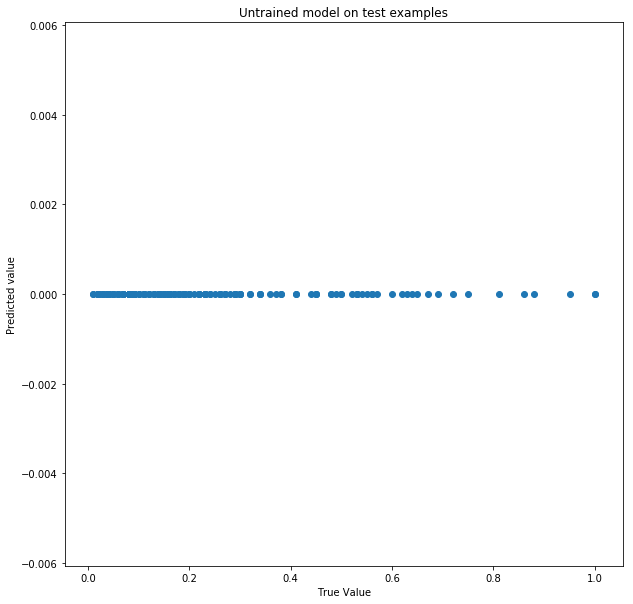

Train the model, with early stopping, restoring best weights
Train on 1596 samples
Epoch 1/100
1596/1596 [==============================] - 0s 311us/sample - loss: 0.0348 - mse: 0.0348 - mae: 0.1293
Epoch 2/100
1596/1596 [==============================] - 0s 173us/sample - loss: 0.0234 - mse: 0.0234 - mae: 0.1056
Epoch 3/100
1596/1596 [==============================] - 0s 173us/sample - loss: 0.0210 - mse: 0.0210 - mae: 0.1003
Epoch 4/100
1596/1596 [==============================] - 0s 169us/sample - loss: 0.0206 - mse: 0.0206 - mae: 0.0984
Epoch 5/100
1596/1596 [==============================] - 0s 164us/sample - loss: 0.0201 - mse: 0.0201 - mae: 0.0978
Epoch 6/100
1596/1596 [==============================] - 0s 166us/sample - loss: 0.0188 - mse: 0.0188 - mae: 0.0945
Epoch 7/100
1596/1596 [==============================] - 0s 169us/sample - loss: 0.0191 - mse: 0.0191 - mae: 0.0954
Epoch 8/100
1596/1596 [==============================] - 0s 175us/sample - loss: 0.0187 - mse: 0.0187 - m

1596/1596 [==============================] - 0s 168us/sample - loss: 0.0093 - mse: 0.0093 - mae: 0.0669
Epoch 71/100
1596/1596 [==============================] - 0s 159us/sample - loss: 0.0099 - mse: 0.0099 - mae: 0.0681
Epoch 72/100
1596/1596 [==============================] - 0s 162us/sample - loss: 0.0090 - mse: 0.0090 - mae: 0.0660
Epoch 73/100
1596/1596 [==============================] - 0s 167us/sample - loss: 0.0093 - mse: 0.0093 - mae: 0.0665
Epoch 74/100
1596/1596 [==============================] - 0s 162us/sample - loss: 0.0086 - mse: 0.0086 - mae: 0.0651
Epoch 75/100
1596/1596 [==============================] - 0s 185us/sample - loss: 0.0086 - mse: 0.0086 - mae: 0.0646
Epoch 76/100
1596/1596 [==============================] - 0s 170us/sample - loss: 0.0084 - mse: 0.0084 - mae: 0.0631
Epoch 77/100
1596/1596 [==============================] - 0s 169us/sample - loss: 0.0085 - mse: 0.0085 - mae: 0.0630
Epoch 78/100
1596/1596 [==============================] - 0s 175us/sample - l

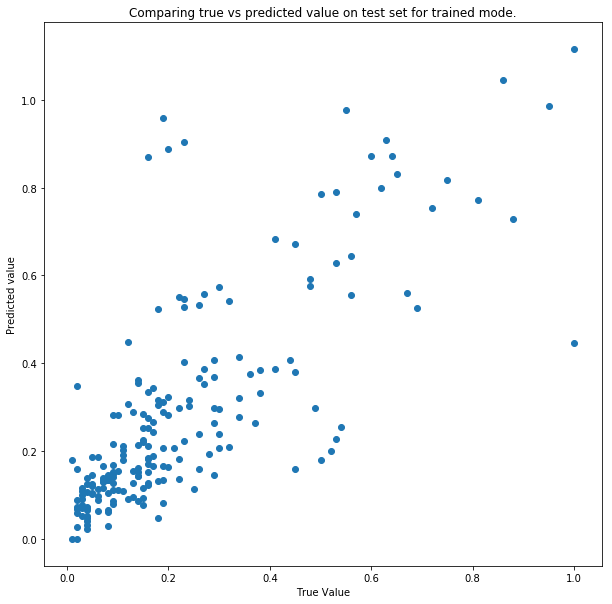

Plot Group Fairness losses


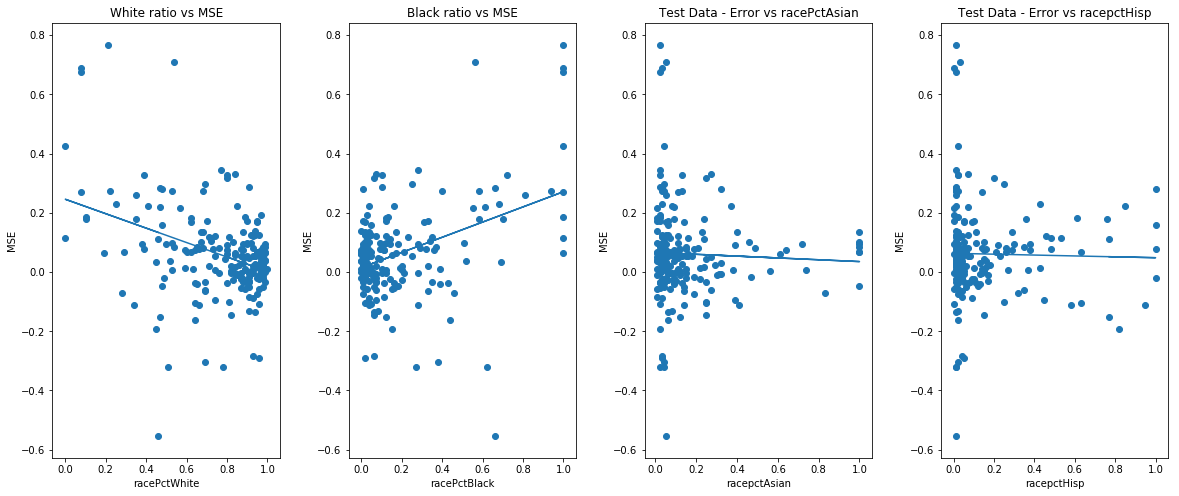

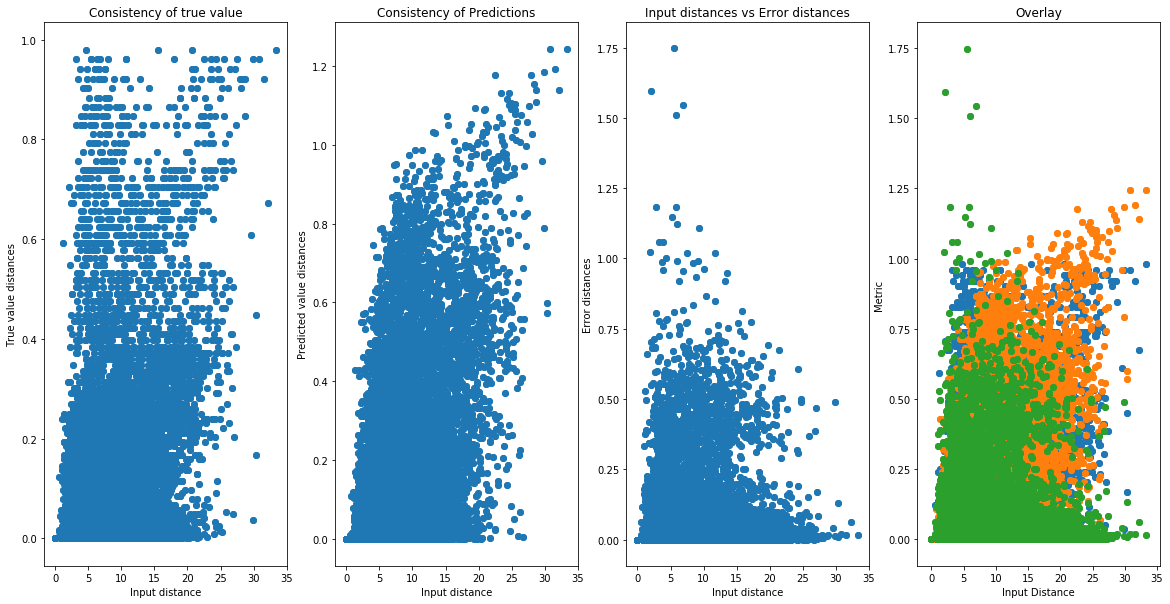

In [57]:
model_accuracy_loss = run_experiments(train_validation_test_examples, train_validation_test_targets, [False, False], [0, 0])

Input index dictionary:  {'racePctWhite': 3, 'racePctBlack': 2, 'racePctAsian': 4, 'racePctHisp': 5}
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 99)]              0         
_________________________________________________________________
pre_dense_1_128 (Dense)      (None, 128)               12800     
_________________________________________________________________
pre_dense_2_64 (Dense)       (None, 64)                8256      
_________________________________________________________________
repr_layer (Dense)           (None, 99)                6435      
_________________________________________________________________
post_dense_1_128 (Dense)     (None, 128)               12800     
_________________________________________________________________
post_dense_2_64 (Dense)      (None, 64)                8256      
________________________

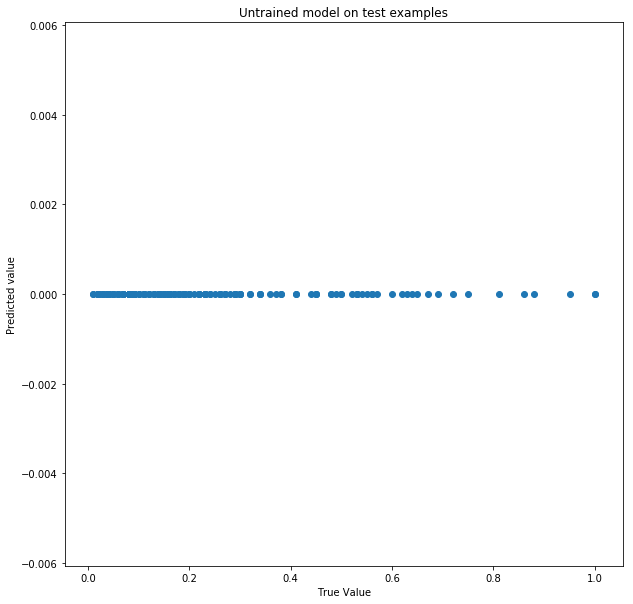

Train the model, with early stopping, restoring best weights
Train on 1596 samples
Epoch 1/100
1596/1596 [==============================] - 1s 608us/sample - loss: 0.1679 - mse: 0.0681 - mae: 0.1846
Epoch 2/100
1596/1596 [==============================] - 0s 274us/sample - loss: 0.1334 - mse: 0.0485 - mae: 0.1594
Epoch 3/100
1596/1596 [==============================] - 0s 272us/sample - loss: 0.1206 - mse: 0.0437 - mae: 0.1541
Epoch 4/100
1596/1596 [==============================] - 0s 255us/sample - loss: 0.1192 - mse: 0.0442 - mae: 0.1518
Epoch 5/100
1596/1596 [==============================] - 0s 275us/sample - loss: 0.1233 - mse: 0.0378 - mae: 0.1377
Epoch 6/100
1596/1596 [==============================] - 0s 278us/sample - loss: 0.1193 - mse: 0.0363 - mae: 0.1376
Epoch 7/100
1596/1596 [==============================] - 0s 283us/sample - loss: 0.1208 - mse: 0.0394 - mae: 0.1374
Epoch 8/100
1596/1596 [==============================] - 0s 257us/sample - loss: 0.1181 - mse: 0.0341 - m

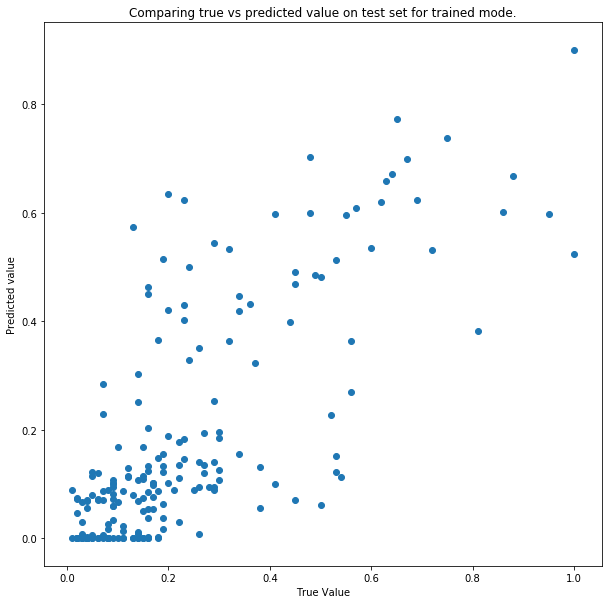

Plot Group Fairness losses


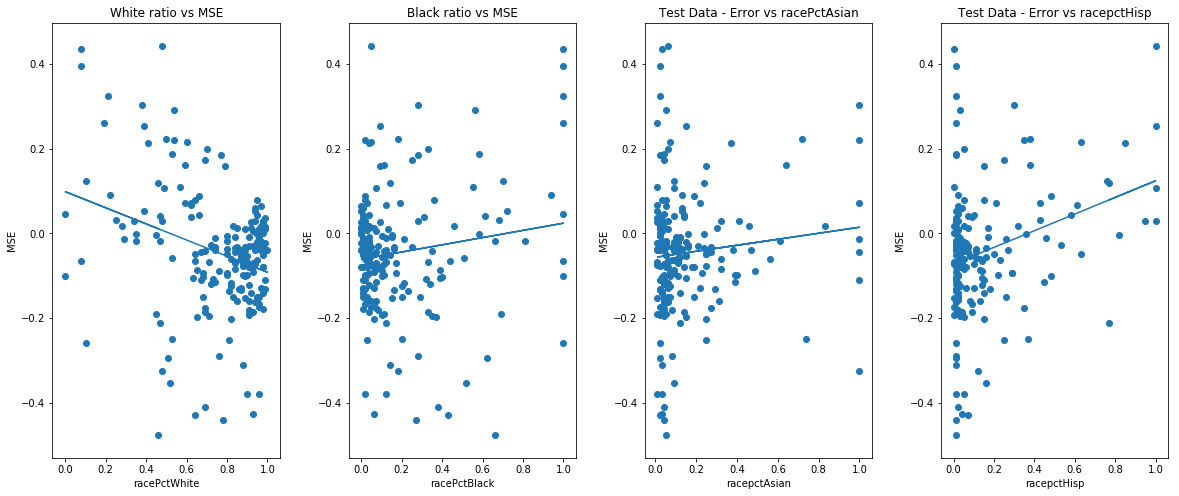

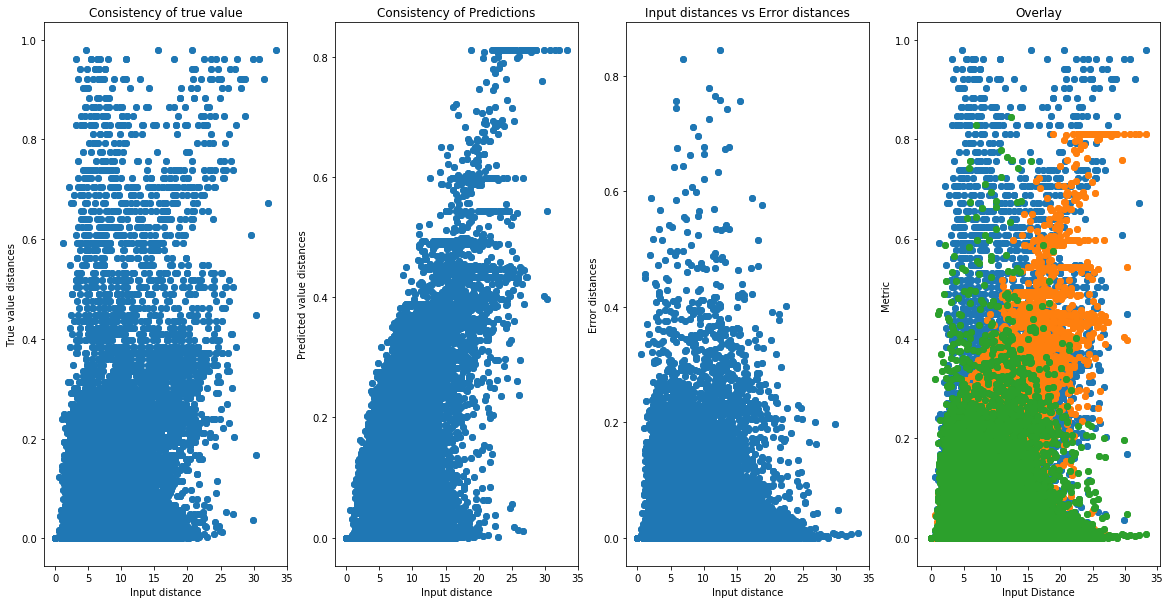

In [58]:
model_similarity_loss = run_experiments(train_validation_test_examples, train_validation_test_targets, [True, False], [0.5, 0])

# Evaluate consistency of true value in the new space

In [59]:
def get_repr_layer_model(model):
    layer_name = 'repr_layer'
    repr_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    return repr_layer_model

def get_intermediate_output(_input, model):
    repr_layer_model = get_repr_layer_model(model)
    return repr_layer_model.predict(_input)
    

In [60]:
accuracy_loss_model_intermediate_output = get_intermediate_output(test_examples_3, model_accuracy_loss)
similarity_loss_intermediate_output = get_intermediate_output(test_examples_3, model_similarity_loss)

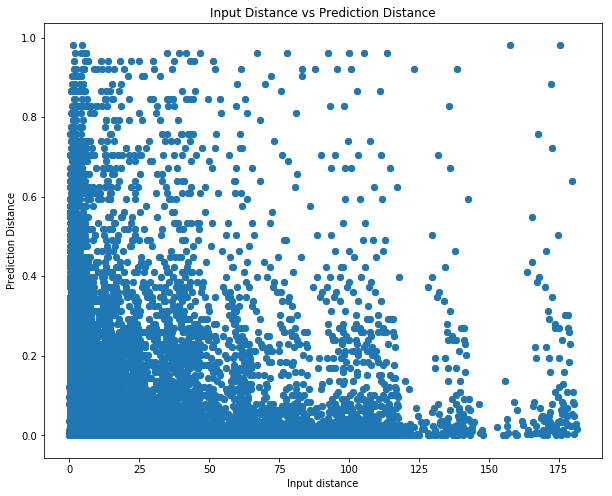

In [61]:
plot_consistency(similarity_loss_intermediate_output, test_targets_3)

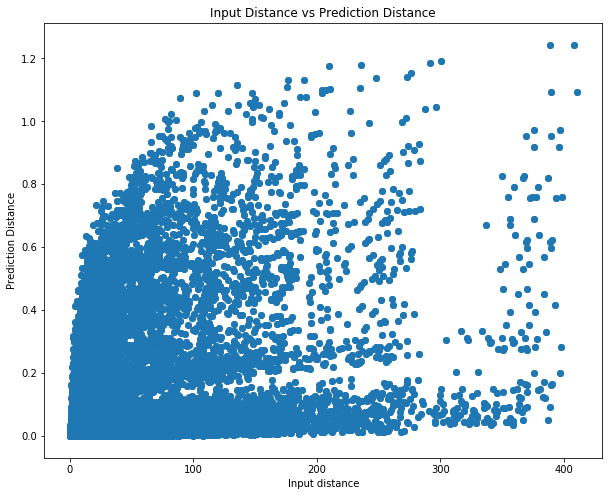

In [62]:
plot_consistency(accuracy_loss_model_intermediate_output,model_accuracy_loss.predict(test_examples_3))

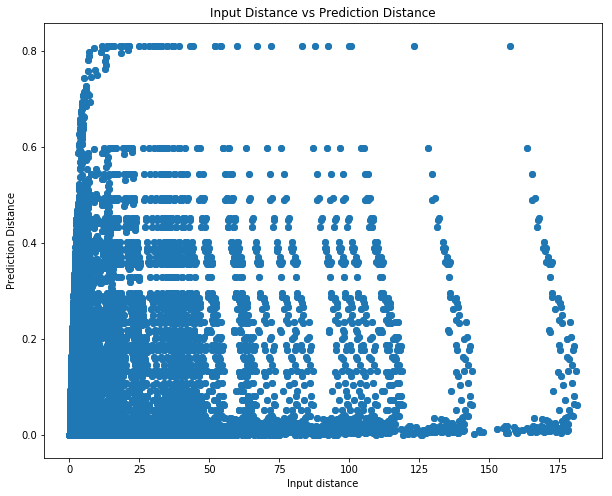

In [63]:
plot_consistency(similarity_loss_intermediate_output, model_similarity_loss.predict(test_examples_3))

# Apply group fairness metric

Input index dictionary:  {'racePctWhite': 3, 'racePctBlack': 2, 'racePctAsian': 4, 'racePctHisp': 5}
Errors shape:  (None, None) racePctWhite.shape:  (None, 1)
cc_vec shape:  (1, 4)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 99)]              0         
_________________________________________________________________
pre_dense_1_128 (Dense)      (None, 128)               12800     
_________________________________________________________________
pre_dense_2_64 (Dense)       (None, 64)                8256      
_________________________________________________________________
repr_layer (Dense)           (None, 99)                6435      
_________________________________________________________________
post_dense_1_128 (Dense)     (None, 128)               12800     
_________________________________________________________________
post_dens

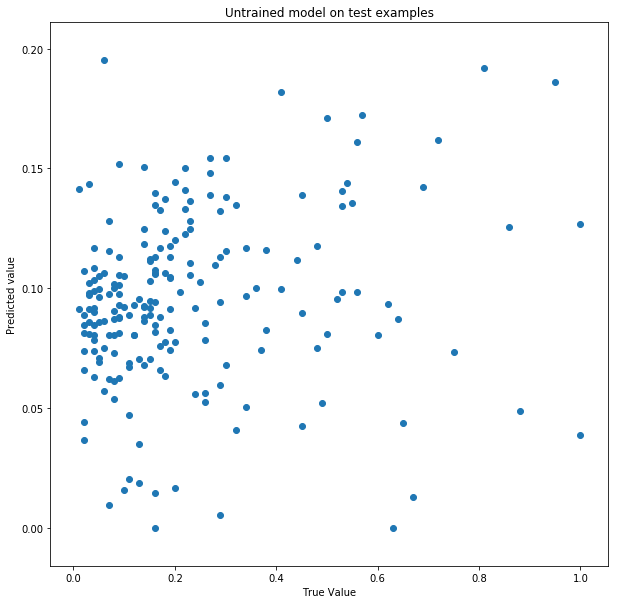

Train the model, with early stopping, restoring best weights
Train on 1596 samples
Epoch 1/100
1596/1596 [==============================] - 1s 791us/sample - loss: 0.1258 - mse: 0.0448 - mae: 0.1552
Epoch 2/100
1596/1596 [==============================] - 0s 300us/sample - loss: 0.1095 - mse: 0.0356 - mae: 0.1384
Epoch 3/100
1596/1596 [==============================] - 0s 281us/sample - loss: 0.1067 - mse: 0.0333 - mae: 0.1331
Epoch 4/100
1596/1596 [==============================] - 0s 289us/sample - loss: 0.0960 - mse: 0.0287 - mae: 0.1221
Epoch 5/100
1596/1596 [==============================] - 0s 273us/sample - loss: 0.0943 - mse: 0.0284 - mae: 0.1211
Epoch 6/100
1596/1596 [==============================] - 0s 277us/sample - loss: 0.0959 - mse: 0.0265 - mae: 0.1169
Epoch 7/100
1596/1596 [==============================] - 0s 300us/sample - loss: 0.0979 - mse: 0.0272 - mae: 0.1172
Epoch 8/100
1596/1596 [==============================] - 0s 273us/sample - loss: 0.0904 - mse: 0.0276 - m

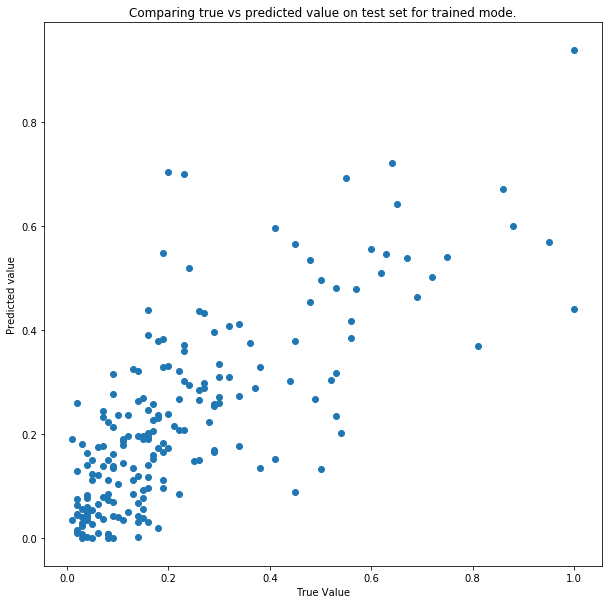

Plot Group Fairness losses


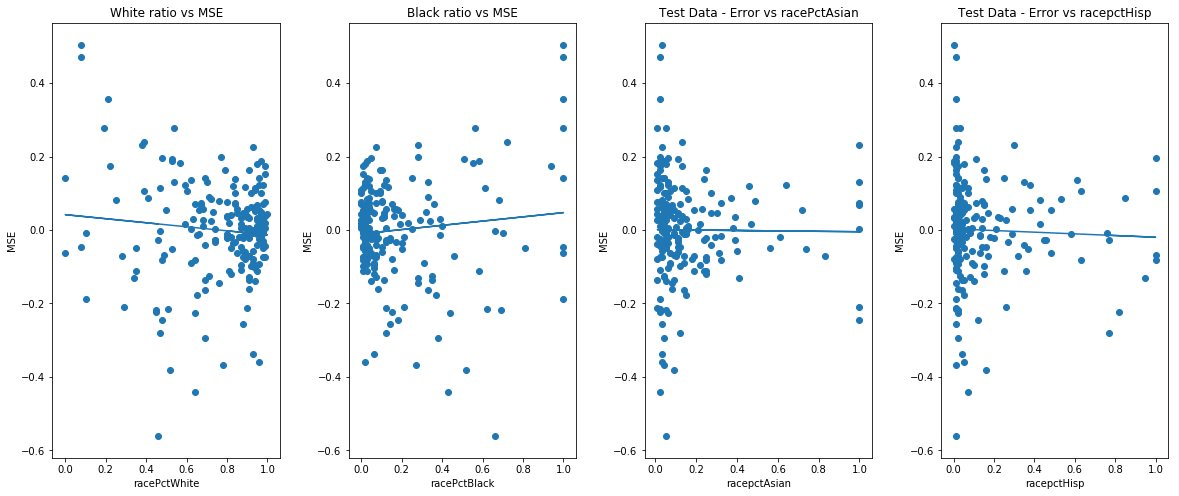

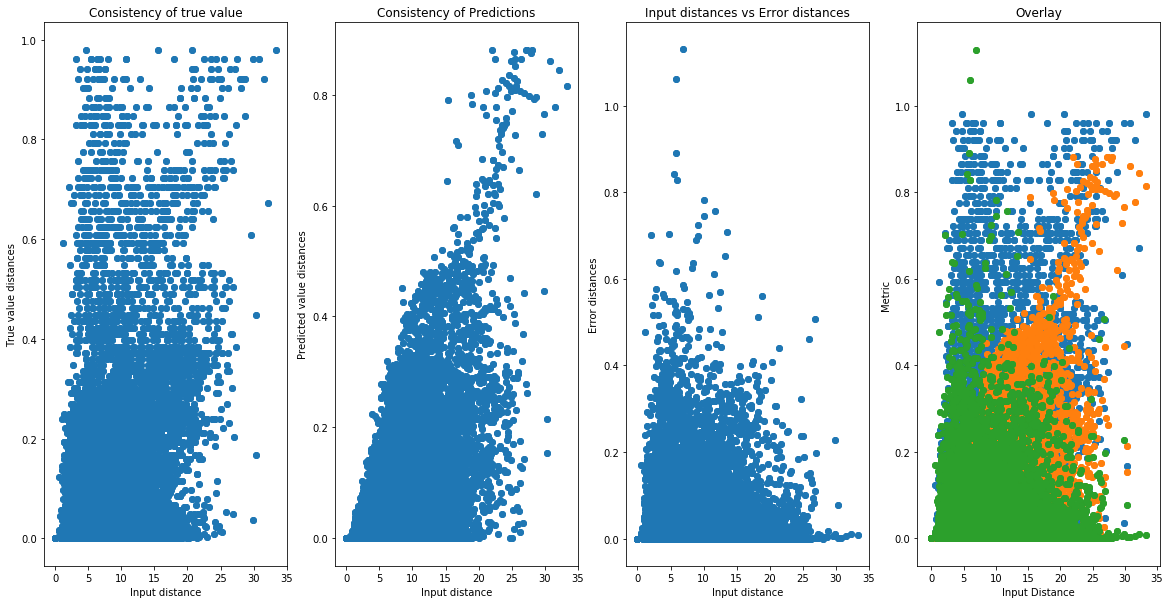

In [64]:
model_group_fairness_loss = run_experiments(train_validation_test_examples, train_validation_test_targets, [False, True], [0, 0.5])

## Combine individual with group fairness

Input index dictionary:  {'racePctWhite': 3, 'racePctBlack': 2, 'racePctAsian': 4, 'racePctHisp': 5}
Errors shape:  (None, None) racePctWhite.shape:  (None, 1)
cc_vec shape:  (1, 4)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 99)]              0         
_________________________________________________________________
pre_dense_1_128 (Dense)      (None, 128)               12800     
_________________________________________________________________
pre_dense_2_64 (Dense)       (None, 64)                8256      
_________________________________________________________________
repr_layer (Dense)           (None, 99)                6435      
_________________________________________________________________
post_dense_1_128 (Dense)     (None, 128)               12800     
_________________________________________________________________
post_dens

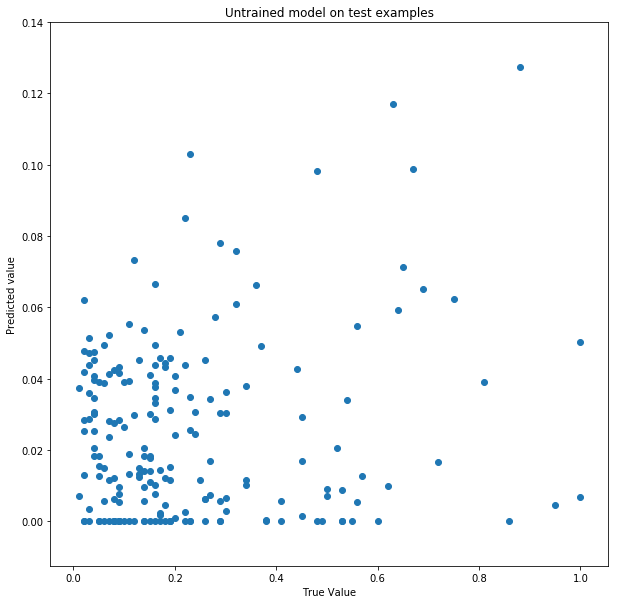

Train the model, with early stopping, restoring best weights
Train on 1596 samples
Epoch 1/100
1596/1596 [==============================] - 2s 1ms/sample - loss: 0.2321 - mse: 0.0541 - mae: 0.1685
Epoch 2/100
1596/1596 [==============================] - 1s 413us/sample - loss: 0.2103 - mse: 0.0482 - mae: 0.1588
Epoch 3/100
1596/1596 [==============================] - 1s 364us/sample - loss: 0.2125 - mse: 0.0508 - mae: 0.1588
Epoch 4/100
1596/1596 [==============================] - 1s 353us/sample - loss: 0.1989 - mse: 0.0424 - mae: 0.1454
Epoch 5/100
1596/1596 [==============================] - 1s 357us/sample - loss: 0.1770 - mse: 0.0404 - mae: 0.1439
Epoch 6/100
1596/1596 [==============================] - 1s 372us/sample - loss: 0.1932 - mse: 0.0443 - mae: 0.1511
Epoch 7/100
1596/1596 [==============================] - 1s 350us/sample - loss: 0.1787 - mse: 0.0422 - mae: 0.1467
Epoch 8/100
1596/1596 [==============================] - 1s 371us/sample - loss: 0.1895 - mse: 0.0463 - mae

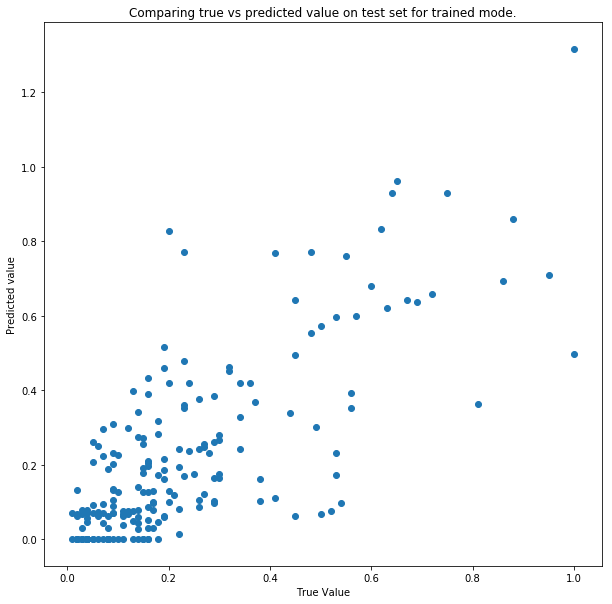

Plot Group Fairness losses


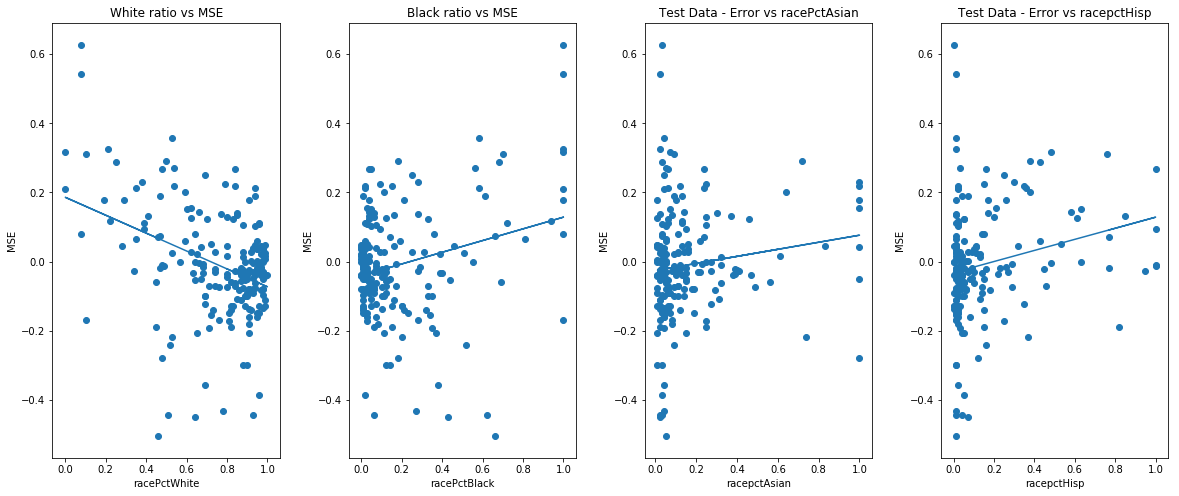

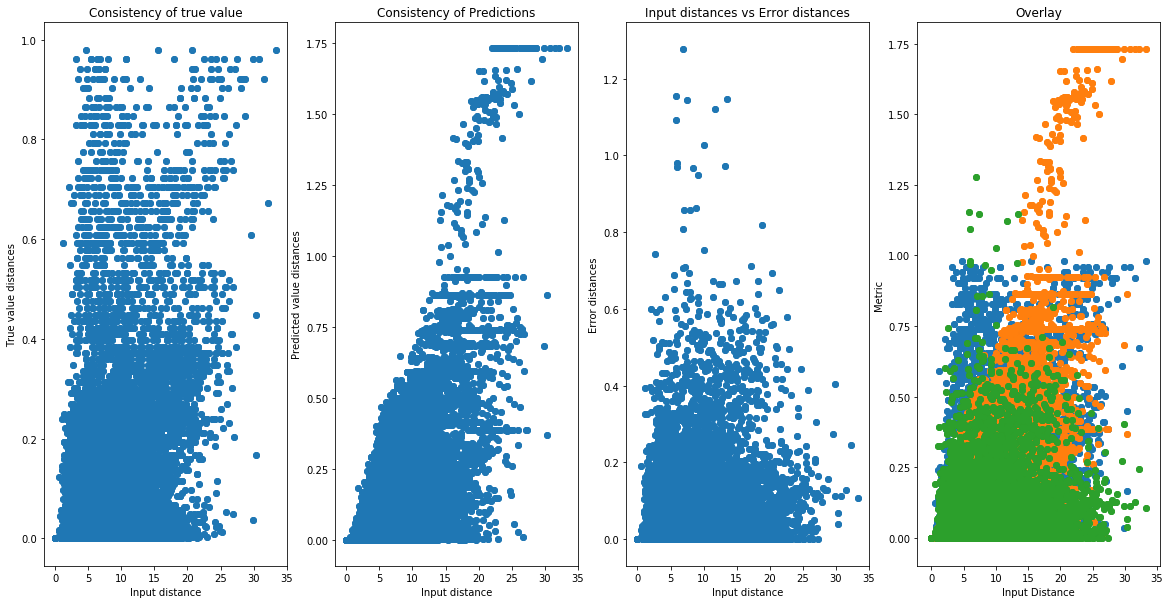

In [65]:
model_group_fairness_loss = run_experiments(train_validation_test_examples, train_validation_test_targets, [True, True], [0.5, 0.5])